In [1]:
### Denoising Adverarial Autoencoder (omniglot) : Version 2 : matching q*(z|x) to p(z)
#if n_hidden==n uses nD normal

In [ ]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn import neighbors

#for log likelihood
from ll import ll
#using code from goodfellow repo insted
from parzen import theano_parzen,get_nll,cross_validate_sigma

floatX=theano.config.floatX

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN not available)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=200    #size of encoding
        self.alpha=1e-5      #learnig rate
        self.sigma=0.5       #standard deviation of gaussian corruption process
        self.batchsize=64    #batch size used for training
        self.epoch=1000      #number of training iterations
        self.upper_bound=0.75 #only train discriminator is the encoder adv loss is less than this upper bound
        self.M=5             #number of intergration steps
        
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):
    
    #Encoder x* --> z
    enc=InputLayer(shape=(None,1,105,105))
    enc=flatten(incoming=enc, outdim=2)
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=105*105,nonlinearity=sigmoid)
    dec=reshape(incoming=dec, shape=(-1, 1, 105, 105))
    
    #Discriminator z --> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis
    

In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #opts.sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.tensor4('x') #MNIST are saved as vectors
    z=T.matrix('z')

    #The outputs for training autoencoder:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded corrupted input
    
    #The outputs for training encoder w/ discriminative loss
    zi=T.zeros((x.shape[0],opts.n_hidden))
    for i in range(opts.M): #corrupt a single x sample M times and encode that corrupted sample
        corr_x_i=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
        zi+=get_output(enc,corr_x_i) #sum z_i's
    z_fake=zi/opts.M #the mean enocoded z
        
    p_fake=get_output(dis,z_fake) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #Prevent bce --> NAN
    p_real=T.clip(p_real, 0.001, 0.999)
    p_fake=T.clip(p_fake,0.001, 0.999)
    dec_enc_x_corr=T.clip(dec_enc_x_corr,0.001,0.99)
    
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples (w/out corrupting)
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples
    
    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()

    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()

    #The updates
    update_rec=adam(J_rec, params_enc+params_dec,learning_rate=opts.alpha) #update the encoder and decoder w/ reconstruction loss
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc, params_enc,learning_rate=opts.alpha) #update the encoder w/ adversarial loss

    #The theano training functions
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #synthesise samples
    encode=theano.function(inputs=[x],outputs=encoding) #encode samples
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction]) #corrupt and reconstruct samples
    
    return train_rec,train_dis,train_enc,  sample,encode,reconstruct, enc,dec,dis
    
    

In [6]:
##Load the training, testing and validation datasets
#(N.B. in paper the testing datasets have different names:
# trainig (paper: training), testing (paper: evaluation), validation (paper: testing))
def load_data():
    x_train=np.load('../../InData/omniglot/omni_back_shfl_X.npy', mmap_mode='r')
    y_train=np.load('../../InData/omniglot/omni_back_shfl_Y.npy',mmap_mode='r')
    x_test=np.load('../../InData/omniglot/omni_eval_X.npy',mmap_mode='r')
    y_test=np.load('../../InData/omniglot/omni_eval_Y.npy', mmap_mode='r')

    x_temp=np.load('../../InData/omniglot/omni_back_X.npy',mmap_mode='r')
    y_temp=np.load('../../InData/omniglot/omni_back_Y.npy',mmap_mode='r')
    x_val=np.reshape(np.concatenate([x_temp[i] for i in range(0,x_temp.shape[0],20)]),(-1,1,105,105))
    y_val=[y_temp[i] for i in range(0,x_temp.shape[0],20)]
    
    print 'x_train  \t\t | y_train \t| x_test  \t\t| y_test \t  | x_val   \t\t | y_val \n-----------------------------------------------------------------------------------------------------------'
    print np.shape(x_train),'\t',np.shape(y_train),'\t',np.shape(x_test),'\t',np.shape(y_test),'\t\t',np.shape(x_val),'\t',np.shape(y_val)
    return x_train.astype(floatX), y_train, x_test.astype(floatX), y_test, x_val.astype(floatX), y_val

In [7]:
#if opts.n_hidden=2 will give a 2D 10-GMM otherise gives a multivariate gaussian
def P_z(size,type=None):
    if size[1] is 2:
        #samples at 2D 10-GMM
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_val,y_val=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)
    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    
    print 'epoch   batch   cost_dis   cost_enc   cost_rec   time '
    for e in range(opts.epoch):
        timer = time.time()
        for b in np.random.permutation(range(batches)):
            #draw a batch of latent samples from the prior
            Z=P_z(size=(opts.batchsize,opts.n_hidden))
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            #train the discriminator
            cost_dis.append(train_dis(X,Z))
            #train the encoder (w/ adversarial) 
            cost_enc.append(train_enc(X))
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            cost_rec.append(train_rec(X))
            
        print "%d \t %d  \t %.3f \t %.3f \t %.3f \t %.2f" % (e,b,cost_dis[-1],cost_enc[-1],cost_rec[-1], time.time()-timer)
    
    return sample,encode,reconstruct,cost_enc,cost_rec,cost_dis
    

In [ ]:
##Training 
sample,encode,reconstruct,cost_enc,cost_rec,cost_dis=train(myOpts)

In [ ]:
#Save all models:
import pickle
dir='DAAE_v2_omni_params'
pickle.dump(sample,open(dir+'/sample.pkl','w'))
pickle.dump(encode,open(dir+'/encode.pkl','w'))
pickle.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
pickle.dump(myOpts,open(dir+'/myOpts.pkl','w'))
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)

In [9]:
#load all models:
import pickle
# dir='DAAE_v2_omni_params/'
dir='../Experiments/omni/DAAE_v2_noise_M5/DAAE_v2_omni_params/'
sample=pickle.load(open(dir+'/sample.pkl','r'))
encode=pickle.load(open(dir+'/encode.pkl','r'))
reconstruct=pickle.load(open(dir+'/reconstruct.pkl','r'))
myOpts=pickle.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma,', n_hidden',myOpts.n_hidden, ', M', myOpts.M

sigma: 0.5 , n_hidden 200 , M 5


x_train  		 | y_train 	| x_test  		| y_test 	  | x_val   		 | y_val 
-----------------------------------------------------------------------------------------------------------
(18316, 1, 105, 105) 	(18316,) 	(13180, 1, 105, 105) 	(13180,) 		(964, 1, 105, 105) 	(964,)


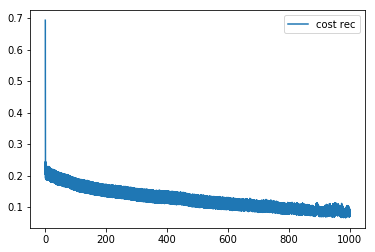

In [10]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
#plt.plot(y,cost_dis,label='cost dis') #plot discriminator loss
#plt.plot(y,cost_enc,label='cost enc') #plot encoder loss
plt.plot(y,cost_rec,label='cost rec')  #plot recosntruction loss
plt.legend()

mean squared error loss on eval: 0.0330818 +/- 0.00423119969013


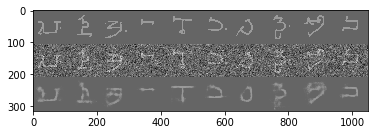

In [11]:
#Apply reconstruction to all the test images
x_rec_loss,x_rec=reconstruct(x_val)
print "mean squared error loss on eval:", np.mean(x_rec_loss),'+/-', np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])
egs=10 #no of random examples to show
x_noise=(x_val[:egs].reshape(egs,105,105)+np.random.normal(loc=0.0, scale=myOpts.sigma, size=(egs,105,105))).reshape(egs,105,105)
plt.imshow(np.hstack(np.hstack(([x_val[:egs].reshape(egs,105,105),x_noise,x_rec[:egs].reshape(egs,105,105)]))),cmap='gray')
plt.figure()

In [12]:
##Classification
#Train a linear SVM on the features from x_train
enc_train=encode(x_train) #extract features for training data
enc_val=encode(x_val) #extract features for validation data
classifier=SVC().fit(enc_train,y_train) #default rbf kernel
y_val=np.asarray(y_val, dtype=int)
score=classifier.score(enc_val,y_val)
print "mean accuracy (SVM):",score*100,'%'

mean accuracy (SVM): 34.0248962656 %


In [13]:
## 20 class classfication (for 1st 20 classes of the eval data set using leave one out method)
enc_test=encode(x_test[:20*20]) #take all 20 examples of 1st 20 classes
print np.shape(enc_test)

all_score_test=[]
all_score_train=[]
for i in range(20): #keep out the ith samples, train on the rest
    print i
    x_20_test=enc_test[i::20]; #take the ith samples for testing
    y_20_test=y_test[:20*20][i::20]; #take the ith samples for testing for 1st 20 classes
    x_20_train=np.delete(enc_test, range(i,enc_test.shape[0],20), axis=0) #remove the ith samples for training
    y_20_train=np.delete(y_test[:20*20], range(i,enc_test.shape[0],20), axis=0) #remove the ith samples for training for the 1st 20 classes

    print 'stand out samples:\n',range(i,enc_test.shape[0],20)

    print np.unique(y_20_test),'\n', np.unique(y_20_train)
    print np.shape(x_20_test), np.shape(x_20_train), np.shape(y_20_test), np.shape(y_20_train)

    classifier=SVC(kernel='linear').fit(x_20_train,y_20_train) #default rbf kernel
    y_val=np.asarray(y_val,dtype=int)
    score_test=classifier.score(x_20_test,y_20_test)
    score_train=classifier.score(x_20_train, y_20_train)
    #print "mean accuracy on 20 classes (Linear SVM  kernel):",score_test*100,'%'
    #print "mean accuracy on 20 classes (Linear SVM  kernel):",score_train*100,'%'
    all_score_test.append(score_test)
    all_score_train.append(score_train)
print "\n mean test accuracy on ", len(all_score_test), "sets of 20-way classification:", np.mean(all_score_test)*100,"%"
print "\n (mean train accuracy on ", len(all_score_train), "sets of 20-way classification:", np.mean(all_score_train)*100,"%"
print "\n max test accuracy on ", len(all_score_test), "sets of 20-way classification:", np.max(all_score_test)*100,"%"

(400, 200)
0
stand out samples:
[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380]
['0965' '0966' '0967' '0968' '0969' '0970' '0971' '0972' '0973' '0974'
 '0975' '0976' '0977' '0978' '0979' '0980' '0981' '0982' '0983' '0984'] 
['0965' '0966' '0967' '0968' '0969' '0970' '0971' '0972' '0973' '0974'
 '0975' '0976' '0977' '0978' '0979' '0980' '0981' '0982' '0983' '0984']
(20, 200) (380, 200) (20,) (380,)
1
stand out samples:
[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381]
['0965' '0966' '0967' '0968' '0969' '0970' '0971' '0972' '0973' '0974'
 '0975' '0976' '0977' '0978' '0979' '0980' '0981' '0982' '0983' '0984'] 
['0965' '0966' '0967' '0968' '0969' '0970' '0971' '0972' '0973' '0974'
 '0975' '0976' '0977' '0978' '0979' '0980' '0981' '0982' '0983' '0984']
(20, 200) (380, 200) (20,) (380,)
2
stand out samples:
[2, 22, 42, 62, 82, 102, 122, 142, 162, 182, 202, 222, 242, 262, 282, 302, 322, 342, 362, 382]

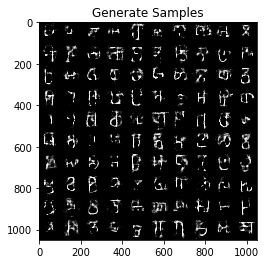

In [14]:
##Samples:
#Draw from the prior and sample (random)
row=col=10
noSamples=row*col
Z=P_z(size=(noSamples,myOpts.n_hidden))  #Draw latent samples from the prior
x_samples=sample(Z).reshape(noSamples,105,105)  #synthesise novel data samples
#display as montage
montage=np.zeros((row*105,col*105))
n=0
for r in range(row):
    for c in range(col):
        montage[r*105:(r+1)*105,c*105:(c+1)*105]=x_samples[n].reshape(105,105); n+=1;
plt.imshow(montage,cmap='gray')
plt.title('Generate Samples')

In [16]:
## log likelihood using theano
noSamples=10**3
Z=P_z(size=(noSamples,myOpts.n_hidden))
feats=np.product(x_train.shape[1:]) #number of dimension
print feats
x_sample=sample(Z)
#cross val to find a sigma
batch_size=32
sigma_range = np.logspace(-1, 0, num=10)
sigma = cross_validate_sigma(x_sample.reshape(-1,feats), x_val.reshape(-1,feats), sigma_range, batch_size)
print "sigma*=",sigma

 11025
0.1
0 18.9730379581 -20378.6072823
0.129154966501
0 11.3530368805 -8930.33581641
0.16681005372
0 10.1754319668 -3196.99389076
0.215443469003
0 8.55655312538 -889.662341721
0.278255940221
0 79.4642369747 -636.172051586
0.35938136638
0 72.6234200001 -1613.92876515
0.464158883361
0 83.5051190853 -3329.79864136
0.599484250319
0 76.498773098 -5488.15287531
0.774263682681
0 8.62471795082 -7911.76430798
1.0
0 8.60708999634 -10494.3873213
sigma*= 0.278255940221


In [17]:
# fit and evaulate
parzen = theano_parzen(x_sample.reshape(-1,feats), sigma)
ll = get_nll(x_test.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test.shape[0])

print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

# valid (draw new set of image samples)
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
parzen = theano_parzen(x_sample.reshape(-1,feats), sigma)
ll = get_nll(x_val.reshape(-1,feats), parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_val.shape[0])
print "Log-Likelihood of valid set = {}, se: {}".format(ll.mean(), se)

0 7.97783517838 -1052.05079969
100 12.0455096429 -706.405678283
200 10.6868425341 -726.995852523
300 10.3013605976 -662.235282155
400 10.1715181766 -649.977371639
Log-Likelihood of test set = -642.614217366, se: 14.2282194457
0 9.63399791718 -691.400193031
Log-Likelihood of valid set = -434.527532242, se: 51.5128854677


In [ ]:
exit()